In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


In [2]:
df = pd.read_csv("public_data.csv")
print(df.head())

      id                                            message             label
0  10480                           start the robotic vacuum      iot_cleaning
1   4210          i am sorry but i think you are not right.    general_negate
2   2443  what is the time difference between california...  datetime_convert
3   5869                              tell me my list names       lists_query
4   2801                 beep when i get an email from john       email_query


In [3]:
df = df.drop(["id"], axis = 1)
df

,message,label
0,start the robotic vacuum,iot_cleaning
1,i am sorry but i think you are not right.,general_negate
2,what is the time difference between california...,datetime_convert
3,tell me my list names,lists_query
4,beep when i get an email from john,email_query
...,...,...
8879,search for a train ticket to newcastle,transport_ticket
8880,is there a food festival in the area,recommendation_events
8881,make the lights blue in here,iot_hue_lightchange
8882,play from favorites song,play_music


## Explore the Basic Properties of the Dataset

## Shape of the dataset

In [4]:
print("Shape of data (rows, cols)=>",df.shape)

Shape of data (rows, cols)=> (8884, 2)


## Check the Null Values

Get the initial information about the dataset:

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8884 entries, 0 to 8883
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  8884 non-null   object
 1   label    8884 non-null   object
dtypes: object(2)
memory usage: 138.9+ KB
None


According to data.info() there is no null values in the dataset but let's verify it:

In [6]:
df.isnull().sum()

message    0
label      0
dtype: int64

**Notice that** according to above numbers there are **No** null values in the dataset! 

If there are any null values in the dataset, we could drop these null values as follows:

`df.dropna(inplace=True)`

`df.isnull().sum()`

## Check the Duplicated Reviews

Let's first find if there are any duplicated records

In [7]:
df.describe(include='all')

,message,label
count,8884,8884
unique,8842,64
top,how do you subtract numbers,qa_definition
freq,3,158


For `label` column there are 8884 rows and 64 unique values. 
However, for `message` column, there exists 8884 rows of which 8842 entries are unique. That is, for `message` column, there are some duplications: 8884 - 8842 = **42**


We can verify the duplications:

In [8]:
df.message.duplicated(keep="first").value_counts()

False    8842
True       42
Name: message, dtype: int64

Drop the duplicated reviews:

In [9]:
df.drop_duplicates(subset="message",keep="first",inplace=True,ignore_index=True)
df.describe()

,message,label
count,8842,8842
unique,8842,64
top,start the robotic vacuum,alarm_set
freq,1,157


## Analyze the Classes (Topics)

### Topic List

In [10]:
topic_list = df.label.unique()
print("Topics:\n", topic_list)

Topics:
 ['iot_cleaning' 'general_negate' 'datetime_convert' 'lists_query'
 'email_query' 'play_radio' 'general_affirm' 'iot_hue_lightdim'
 'music_query' 'iot_wemo_off' 'transport_traffic'
 'recommendation_locations' 'calendar_remove' 'recommendation_movies'
 'social_query' 'iot_wemo_on' 'play_podcasts' 'general_quirky'
 'alarm_remove' 'news_query' 'alarm_query' 'datetime_query' 'iot_coffee'
 'play_music' 'cooking_recipe' 'play_game' 'lists_remove'
 'general_explain' 'takeaway_query' 'iot_hue_lightoff' 'qa_stock'
 'general_repeat' 'qa_currency' 'transport_taxi' 'play_audiobook'
 'social_post' 'transport_query' 'alarm_set' 'music_likeness'
 'recommendation_events' 'general_joke' 'calendar_query'
 'lists_createoradd' 'iot_hue_lightchange' 'iot_hue_lightup'
 'qa_definition' 'email_addcontact' 'general_praise' 'general_confirm'
 'general_commandstop' 'qa_factoid' 'qa_maths' 'audio_volume_down'
 'transport_ticket' 'takeaway_order' 'calendar_set' 'general_dontcare'
 'weather_query' 'music_se

### Number of Topics

In [11]:
number_of_topics = len(topic_list)
print("Number of Topics: ",number_of_topics)

Number of Topics:  64


### Number of Reviews per Topic:

The number of reviews at each category

In [12]:
df.label.value_counts()

alarm_set            157
music_query          157
cooking_recipe       156
datetime_query       156
takeaway_order       156
                    ... 
email_addcontact      69
audio_volume_down     65
music_settings        62
iot_wemo_on           61
iot_hue_lighton       30
Name: label, Length: 64, dtype: int64

Let's depict the number of reviews per topic as a bar chart:

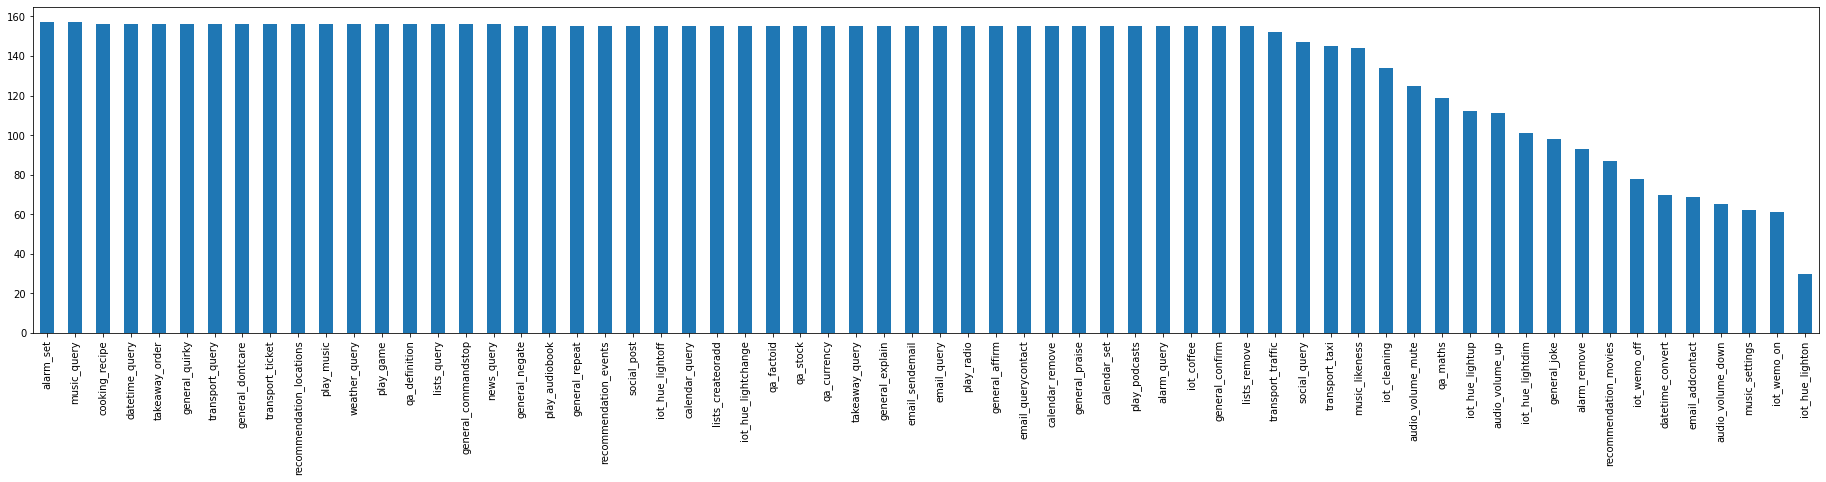

In [13]:
df.label.value_counts().plot.bar(x="Topics",y="Number of Reviews",figsize=(32,6) )

In [14]:

df['category'] = df.label.astype('category').cat.codes
df.head()

,message,label,category
0,start the robotic vacuum,iot_cleaning,26
1,i am sorry but i think you are not right.,general_negate,22
2,what is the time difference between california...,datetime_convert,10
3,tell me my list names,lists_query,36
4,beep when i get an email from john,email_query,13


## Calculate the number of words in each reviews

In [15]:
df['words'] = [len(x.split()) for x in df['message'].tolist()]

df[['words','message']].head()

,words,message
0,4,start the robotic vacuum
1,10,i am sorry but i think you are not right.
2,10,what is the time difference between california...
3,5,tell me my list names
4,8,beep when i get an email from john


## Review Length in terms of Number of Words

In [16]:
df['words'].describe()

count    8842.000000
mean        6.573739
std         2.917879
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        25.000000
Name: words, dtype: float64

In [17]:
X = df['message']
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(7073,)
(7073,)
(1769,)
(1769,)


In [18]:
X = df['message']
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(7073,)
(7073,)
(1769,)
(1769,)


In [19]:
vectorizer = CountVectorizer(min_df=.01, max_df=.8, ngram_range=[1,1], max_features=300, stop_words='english')

pipe = Pipeline([('vec', vectorizer),  ('clf', DecisionTreeClassifier(random_state=223))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.8, max_features=300, min_df=0.01,
                                 ngram_range=[1, 1], stop_words='english')),
                ('clf', DecisionTreeClassifier(random_state=223))])

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

pred_val = pipe.predict(X_val)
print(confusion_matrix(y_val, pred_val))
print(classification_report(y_val, pred_val))

[[20  0  3 ...  0  0  0]
 [ 5 11  1 ...  0  0  0]
 [ 7  1  9 ...  1  0  1]
 ...
 [ 0  0  0 ... 26  0  0]
 [ 0  0  0 ...  0 29  1]
 [ 0  0  0 ...  0  0 14]]
                          precision    recall  f1-score   support

             alarm_query       0.62      0.87      0.73        23
            alarm_remove       0.85      0.61      0.71        18
               alarm_set       0.50      0.36      0.42        25
       audio_volume_down       0.53      0.57      0.55        14
       audio_volume_mute       0.00      0.00      0.00        21
         audio_volume_up       0.62      0.19      0.29        27
          calendar_query       0.20      0.06      0.10        31
         calendar_remove       0.80      0.71      0.75        28
            calendar_set       0.53      0.32      0.40        28
          cooking_recipe       0.33      0.22      0.26        23
        datetime_convert       0.86      0.60      0.71        10
          datetime_query       0.45      0.28      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(y_val, pred_val)
ami = adjusted_mutual_info_score(y_val, pred_val, average_method='arithmetic')

print("ARI: {}".format(ari))
print("AMI: {}".format(ami))

ARI: 0.08306211448463406
AMI: 0.44633394543219135


In [22]:
## Kaggle Predictions


df_test = pd.read_csv('input_data.csv')
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2221 non-null   int64 
 1   message  2221 non-null   object
dtypes: int64(1), object(1)
memory usage: 34.8+ KB


,id,message
0,10873,list the current price of microsoft shares
1,8491,where is the nearest smoke shop
2,4549,please start over.
3,5948,read my lists to me
4,1663,mute volume now


In [23]:
pred_test = pipe.predict(df_test['message'])

my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
print(my_submission.head())

# NOTE: after saving the CSV file, be sure to zip the file before submitting to the competition website!
#my_submission.to_csv('answers.csv', index=False)

      Id              label
0  10873        lists_query
1   8491        qa_currency
2   4549       iot_cleaning
3   5948        qa_currency
4   1663  audio_volume_down
